In [1]:
# 1) Imports & Config
import os, time, pickle, joblib, logging
from collections import Counter
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# EOF


In [2]:
# config
RANDOM_STATE = 42
OUTPUT_DIR = 'models_save'
os.makedirs(OUTPUT_DIR, exist_ok=True)
LOG_FILE = os.path.join(OUTPUT_DIR, 'training_log.txt')
logging.basicConfig(level=logging.INFO, handlers=[logging.FileHandler(LOG_FILE), logging.StreamHandler()])

print('Ready. Outputs ->', OUTPUT_DIR)


DATA_PATH = 'loan_data.csv'  # replace with your file path
assert os.path.exists(DATA_PATH), f"Data file not found: {DATA_PATH}"
df = pd.read_csv(DATA_PATH)

# Set target column
TARGET_COL = 'loan_status'
assert TARGET_COL in df.columns, f"Target column '{TARGET_COL}' not found in dataframe"

print('Loaded', DATA_PATH, 'shape=', df.shape)




Ready. Outputs -> models_save
Loaded loan_data.csv shape= (45000, 14)


In [3]:
# 3) Quick EDA: head / info / describe / missing
print('=== HEAD (first 5 rows) ===')
display(df.head())

print('=== INFO (schema & non-null counts) ===')
buffer = []
# capture info output
print(df.info())

print('=== DESCRIBE (numeric summary) ===')
display(df.describe(include='all'))

print('=== Missing values summary ===')
missing = df.isnull().sum()
missing = missing[missing>0].sort_values(ascending=False)
if len(missing):
    display(missing.to_frame('missing_count'))
else:
    print('✓ No missing values')

# Target distribution quick view
print('=== Target distribution ===')
print(df[TARGET_COL].value_counts(dropna=False))

# %% [markdown]
# Univariate analysis (separate cell)
# - Numeric histograms + boxplot summary for a subset
# - Categorical top counts



=== HEAD (first 5 rows) ===


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


=== INFO (schema & non-null counts) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
count,45000.000000,45000,45000,4.500000e+04,45000.000000,45000,45000.000000,45000,45000.000000,45000.000000,45000.000000,45000.000000,45000,45000.000000
unique,NaN,2,5,NaN,NaN,4,NaN,6,NaN,NaN,NaN,NaN,2,NaN
top,NaN,male,Bachelor,NaN,NaN,RENT,NaN,EDUCATION,NaN,NaN,NaN,NaN,Yes,NaN
freq,NaN,24841,13399,NaN,NaN,23443,NaN,9153,NaN,NaN,NaN,NaN,22858,NaN
mean,27.764178,NaN,NaN,8.031905e+04,5.410333,NaN,9583.157556,NaN,11.006606,0.139725,5.867489,632.608756,NaN,0.222222
std,6.045108,NaN,NaN,8.042250e+04,6.063532,NaN,6314.886691,NaN,2.978808,0.087212,3.879702,50.435865,NaN,0.415744
min,20.000000,NaN,NaN,8.000000e+03,0.000000,NaN,500.000000,NaN,5.420000,0.000000,2.000000,390.000000,NaN,0.000000
25%,24.000000,NaN,NaN,4.720400e+04,1.000000,NaN,5000.000000,NaN,8.590000,0.070000,3.000000,601.000000,NaN,0.000000
50%,26.000000,NaN,NaN,6.704800e+04,4.000000,NaN,8000.000000,NaN,11.010000,0.120000,4.000000,640.000000,NaN,0.000000
75%,30.000000,NaN,NaN,9.578925e+04,8.000000,NaN,12237.250000,NaN,12.990000,0.190000,8.000000,670.000000,NaN,0.000000


=== Missing values summary ===
✓ No missing values
=== Target distribution ===
loan_status
0    35000
1    10000
Name: count, dtype: int64


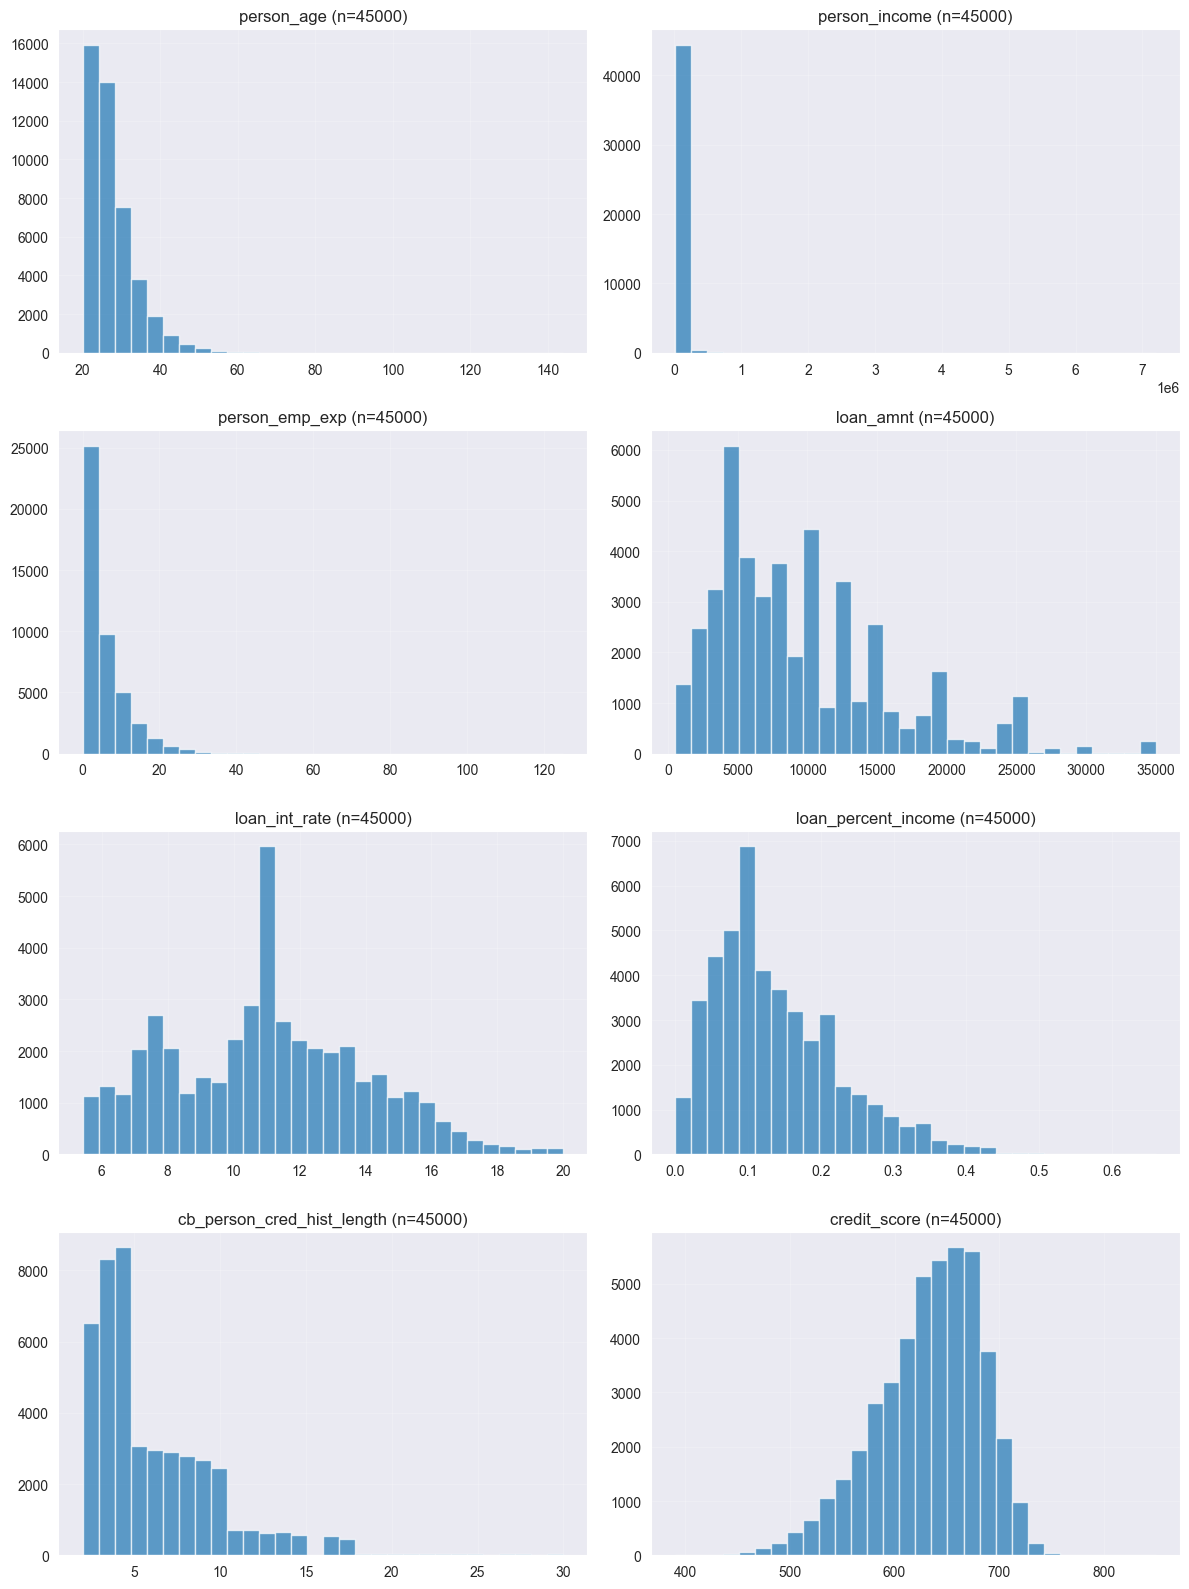

Categorical value counts (top 8 categories each)
-- person_gender --


,count
person_gender,
male,24841
female,20159


-- person_education --


,count
person_education,
Bachelor,13399
Associate,12028
High School,11972
Master,6980
Doctorate,621


-- person_home_ownership --


,count
person_home_ownership,
RENT,23443
MORTGAGE,18489
OWN,2951
OTHER,117


-- loan_intent --


,count
loan_intent,
EDUCATION,9153
MEDICAL,8548
VENTURE,7819
PERSONAL,7552
DEBTCONSOLIDATION,7145
HOMEIMPROVEMENT,4783


-- previous_loan_defaults_on_file --


,count
previous_loan_defaults_on_file,
Yes,22858
No,22142


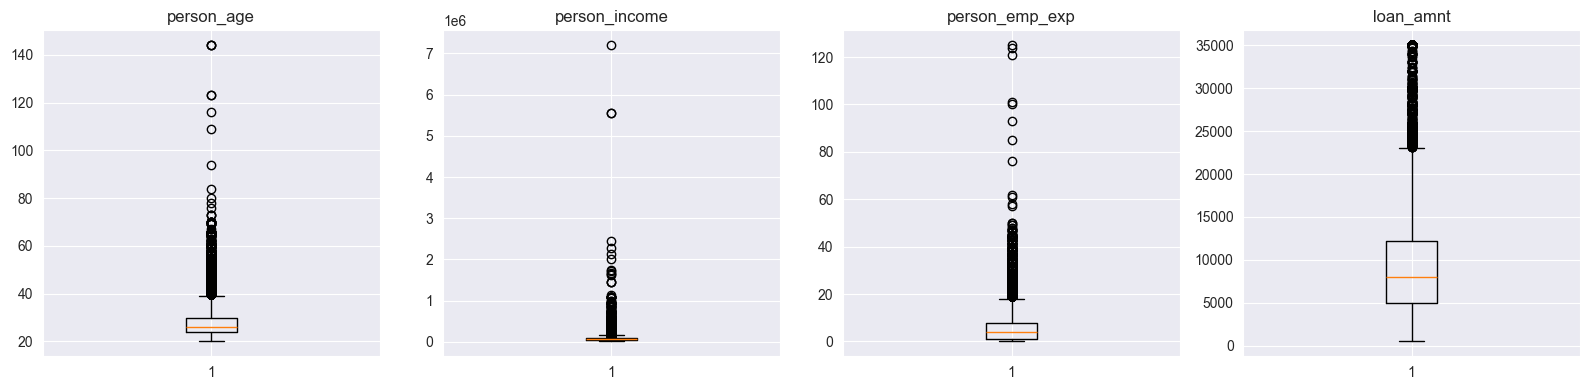

In [4]:
# %%
# 4) Univariate analysis
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if TARGET_COL in numeric_cols:
    numeric_cols.remove(TARGET_COL)
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

# Plot a handful of numeric distributions (up to 8)
plot_nums = numeric_cols[:8]
if plot_nums:
    n = len(plot_nums)
    cols = 2
nrows = (len(plot_nums) + cols - 1) // cols if plot_nums else 0
if nrows:
    fig, axes = plt.subplots(nrows, cols, figsize=(12, 4*nrows))
    axes = axes.flatten()
    for i, col in enumerate(plot_nums):
        data = df[col].dropna()
        ax = axes[i]
        ax.hist(data, bins=30, alpha=0.7)
        ax.set_title(f'{col} (n={data.shape[0]})')
        ax.grid(alpha=0.2)
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()
else:
    print('No numeric columns for univariate plots')

# Categorical top values
print('Categorical value counts (top 8 categories each)')
for c in cat_cols[:8]:
    print('--', c, '--')
    display(df[c].value_counts().head(8).to_frame('count'))

# Simple boxplots for numeric columns (first 4)
if numeric_cols:
    sample = numeric_cols[:4]
    fig, axes = plt.subplots(1, len(sample), figsize=(4*len(sample),4))
    if len(sample)==1:
        axes=[axes]
    for ax, col in zip(axes, sample):
        ax.boxplot(df[col].dropna())
        ax.set_title(col)
    plt.tight_layout()
    plt.show()



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

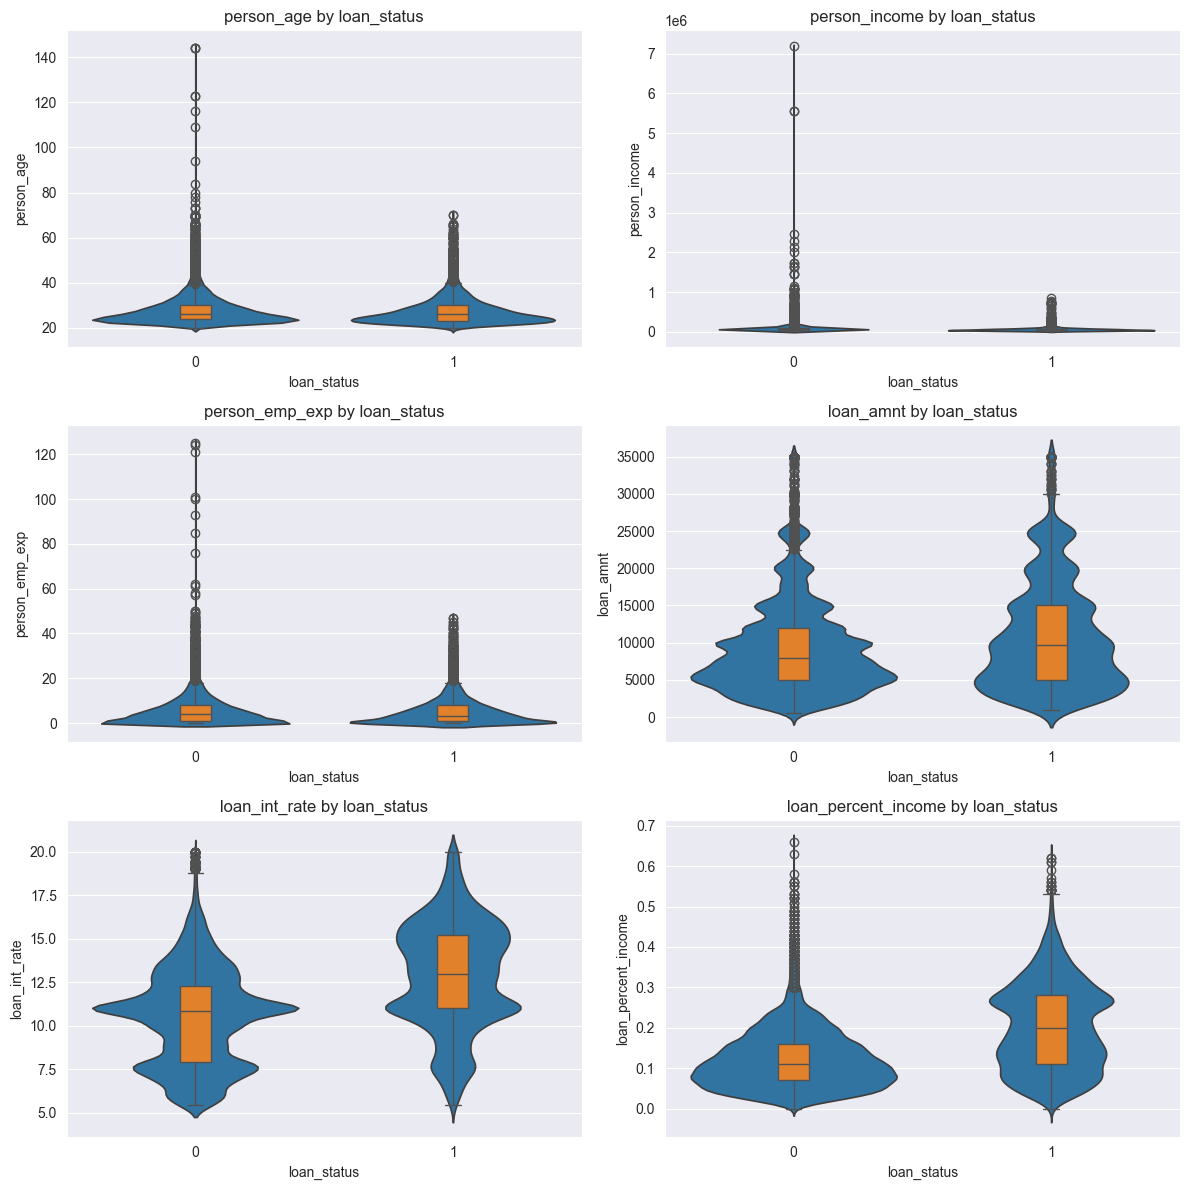

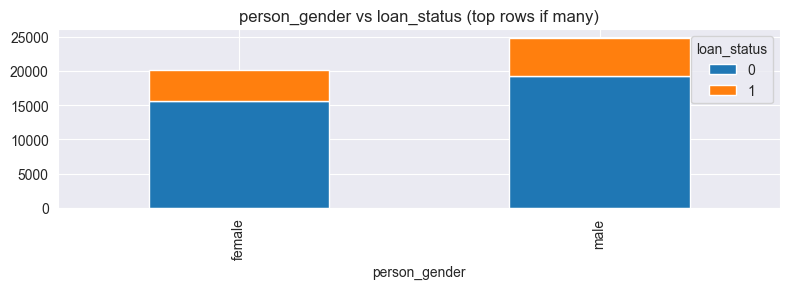

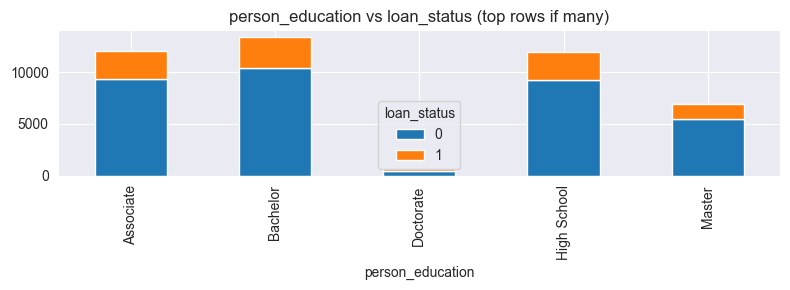

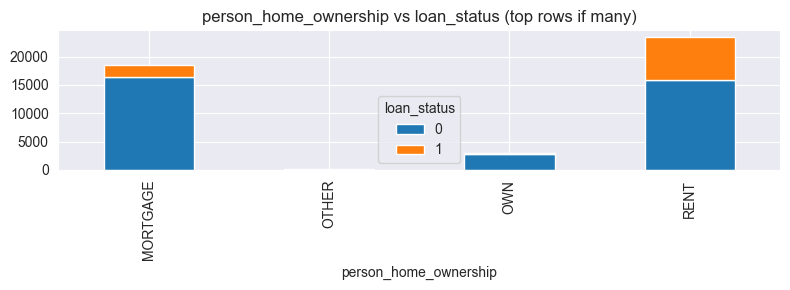

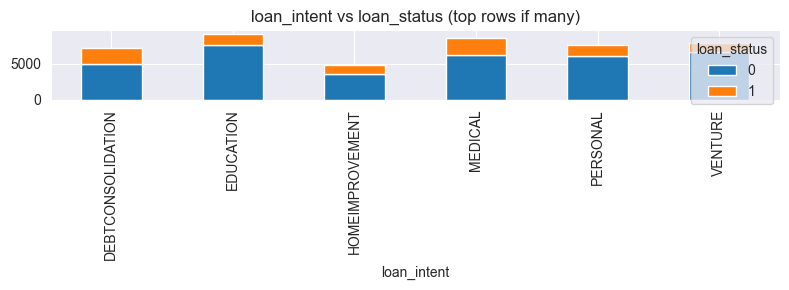

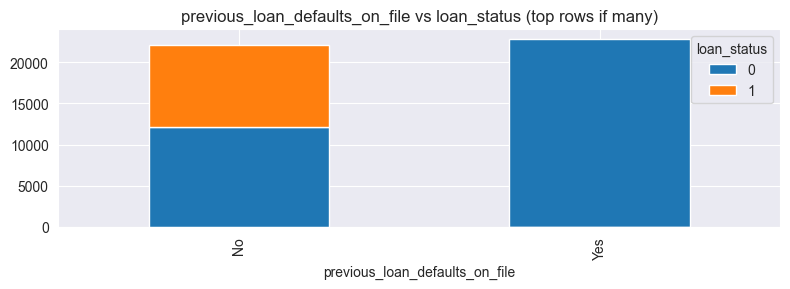

In [5]:

# 5) Bivariate analysis
if numeric_cols:
    sample_num = numeric_cols[:6]
    n = len(sample_num)
    cols = 2
    nrows = (n + cols - 1)//cols
    fig, axes = plt.subplots(nrows, cols, figsize=(12, 4*nrows))
    axes = axes.flatten()
    for i, col in enumerate(sample_num):
        ax = axes[i]
        sns.violinplot(data=df, x=TARGET_COL, y=col, inner=None, ax=ax)
        sns.boxplot(data=df, x=TARGET_COL, y=col, width=0.12, ax=ax, showcaps=True)
        ax.set_title(f'{col} by {TARGET_COL}')
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()
else:
    print('No numeric columns for bivariate plots')

# Categorical vs target (first 6 cat cols)
if cat_cols:
    for c in cat_cols[:6]:
        ct = pd.crosstab(df[c], df[TARGET_COL])
        if ct.shape[0] > 12:
            ct = ct.head(12)
        ct.plot(kind='bar', stacked=True, figsize=(8,3))
        plt.title(f'{c} vs {TARGET_COL} (top rows if many)')
        plt.tight_layout()
        plt.show()
else:
    print('No categorical columns for bivariate plots')


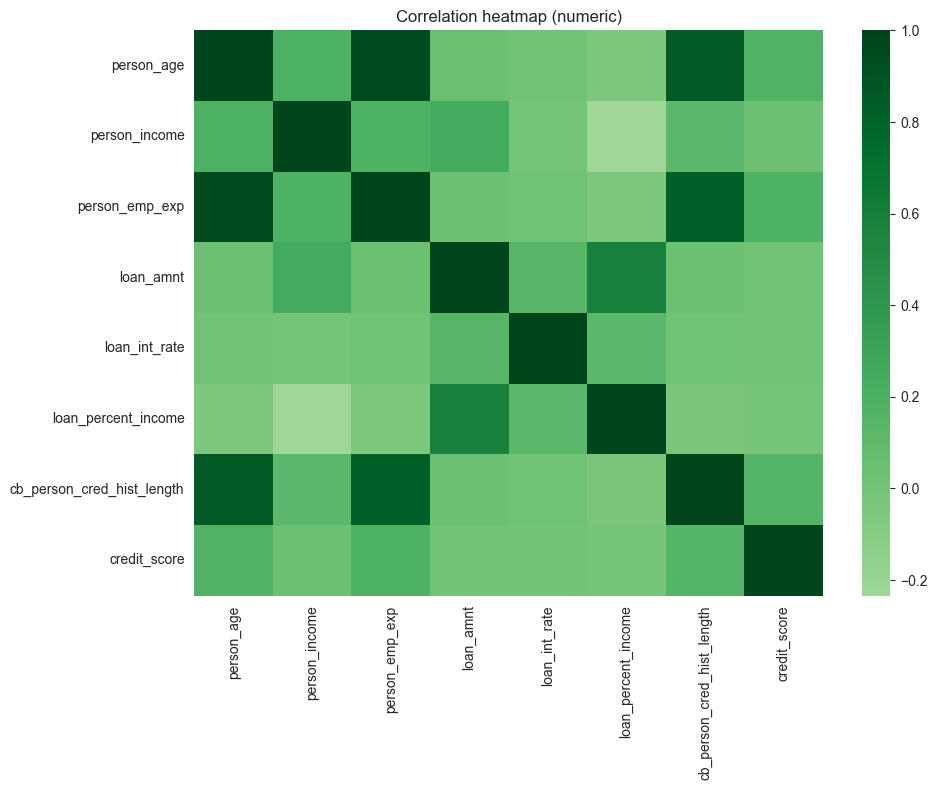

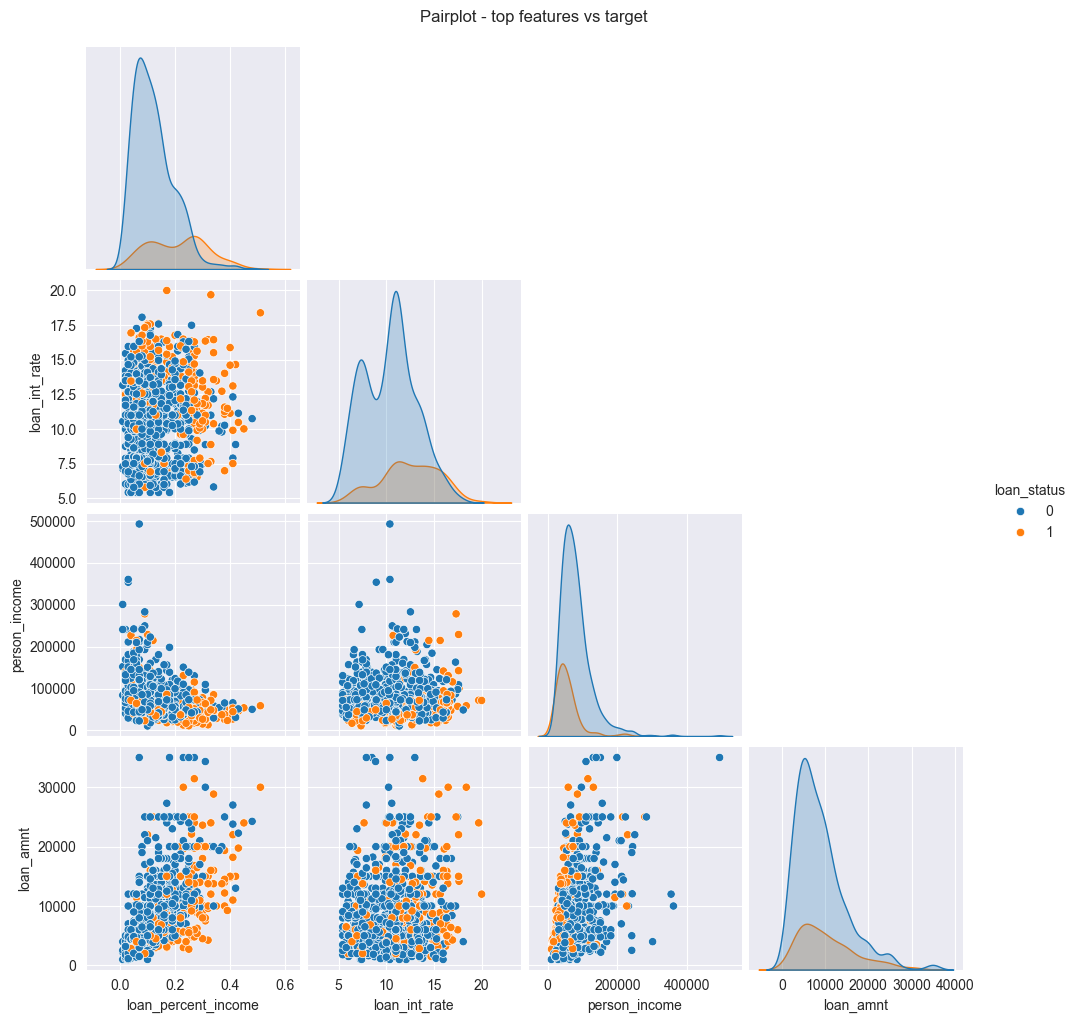

In [6]:
# 6) Multivariate analysis
if numeric_cols and len(numeric_cols) >= 2:
    corr = df[numeric_cols].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, cmap='Greens', center=0)
    plt.title('Correlation heatmap (numeric)')
    plt.tight_layout()
    plt.show()

    # correlation with target if target numeric or encoded later
else:
    print('Not enough numeric columns for correlation heatmap')

# pairplot for top features by correlation magnitude with target (if target is numeric or encoded)
# We'll compute simple correlation to a target-encoded version when possible
if df[TARGET_COL].dtype.name in ['int64','float64'] or df[TARGET_COL].dtype=='object':
    try:
        # encode target to numeric temporarily
        tmap = None
        if df[TARGET_COL].dtype=='object':
            vals = sorted(df[TARGET_COL].unique())
            tmap = {v:i for i,v in enumerate(vals)}
            target_tmp = df[TARGET_COL].map(tmap)
        else:
            target_tmp = df[TARGET_COL]

        corr_with_target = df[numeric_cols].corrwith(target_tmp).abs().sort_values(ascending=False)
        top_feats = corr_with_target.head(4).index.tolist()
        if len(top_feats) >= 2:
            import pandas as pd
            pair_df = df[top_feats + [TARGET_COL]].dropna().sample(min(1000, len(df)))
            sns.pairplot(pair_df, hue=TARGET_COL, corner=True)
            plt.suptitle('Pairplot - top features vs target', y=1.02)
            plt.show()
        else:
            print('Not enough top numeric features for pairplot')
    except Exception as e:
        print('Pairplot skipped:', e)


In [7]:
# %%
# 7) --- FIXED FEATURE ENGINEERING AND PREPROCESSING ---

print("🔧 Running improved EDA and feature engineering...")

# --- 7.1) Create meaningful ratio and interaction features ---

# avoid divide-by-zero
df['loan_percent_income'] = df['loan_amnt'] / (df['person_income'] + 1e-6)

# income per experience (captures job stability)
df['income_per_experience'] = df['person_income'] / (df['person_emp_exp'] + 1)

# credit history length normalized by age (older person but short credit history = potential risk)
df['cred_length_per_age'] = df['cb_person_cred_hist_length'] / (df['person_age'] + 1)

# optional: log-transform highly skewed features
for col in ['person_income', 'loan_amnt', 'loan_percent_income']:
    if (df[col] > 0).all():
        df[col + '_log'] = np.log1p(df[col])

# --- 7.2) Drop raw correlated features ---
# Remove raw values that cause misleading correlations
drop_cols = ['person_income', 'loan_amnt']
df.drop(columns=drop_cols, inplace=True, errors='ignore')
print(f"Dropped raw correlated columns: {drop_cols}")

# --- 7.3) Prepare X, y and encode target if categorical ---
X = df.drop(columns=[TARGET_COL]).copy()
y = df[TARGET_COL].copy()

# map target to integers if categorical and save mapping
target_mapping = None
if y.dtype == 'object' or y.dtype.name == 'category':
    vals = sorted(y.unique())
    target_mapping = {v:i for i,v in enumerate(vals)}
    y = y.map(target_mapping)
    with open(os.path.join(OUTPUT_DIR, 'target_mapping.pkl'), 'wb') as f:
        pickle.dump(target_mapping, f)
    print('Saved target mapping:', target_mapping)

print('Target distribution (encoded):', Counter(y))




🔧 Running improved EDA and feature engineering...
Dropped raw correlated columns: ['person_income', 'loan_amnt']
Target distribution (encoded): Counter({0: 35000, 1: 10000})


In [8]:
# 8) Column types and preprocessor setup
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print('Numeric cols:', num_cols)
print('Categorical cols:', cat_cols)

# try to use TargetEncoder if available
try:
    import category_encoders as ce
    use_target_enc = True
except Exception:
    use_target_enc = False

# numeric pipeline: impute median + scale
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# categorical pipeline: use target encoding if available, else ordinal
if use_target_enc and cat_cols:
    cat_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('target_enc', ce.TargetEncoder())
    ])
else:
    cat_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ])

# final column transformer
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
], remainder='drop')

print("✅ Feature engineering + preprocessing pipeline ready.")

Numeric cols: ['person_age', 'person_emp_exp', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'income_per_experience', 'cred_length_per_age', 'person_income_log', 'loan_amnt_log', 'loan_percent_income_log']
Categorical cols: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
✅ Feature engineering + preprocessing pipeline ready.


In [9]:
# 9) Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
print('Train:', X_train.shape, 'Test:', X_test.shape, 'Train dist:', Counter(y_train))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
N_ITER = 12

# helper function
def run_model_search(name, estimator, param_dist, n_iter=N_ITER):
    print(f"--- TRAINING {name} ---")
    pipe = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=RANDOM_STATE)), ('clf', estimator)])
    search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=n_iter, scoring='f1', cv=cv, n_jobs=-1, random_state=RANDOM_STATE, verbose=0)
    start = time.time()
    search.fit(X_train, y_train)
    elapsed = time.time() - start
    best = search.best_estimator_
    y_pred = best.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)
    path = os.path.join(OUTPUT_DIR, f"{name.lower()}_pipeline.joblib")
    joblib.dump(best, path, compress=3)
    logging.info(f"{name}: acc={acc:.4f}, f1={f1:.4f}, time={elapsed:.1f}s -> saved {path}")
    print(f"Done: acc={acc:.4f}, f1={f1:.4f}, time={elapsed:.1f}s")
    return {'name':name, 'acc':acc, 'f1':f1, 'precision':precision, 'recall':recall, 'time':elapsed, 'path':path, 'best_params': getattr(search,'best_params_', None), 'y_pred': y_pred}


Train: (36000, 16) Test: (9000, 16) Train dist: Counter({0: 28000, 1: 8000})


In [10]:
# %%
# 10) Logistic Regression (cell)
lr = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)
lr_params = {'clf__C': [0.01, 0.1, 1.0, 10.0]}
res_lr = run_model_search('LogisticRegression', lr, lr_params)

--- TRAINING LogisticRegression ---


INFO:root:LogisticRegression: acc=0.8646, f1=0.8723, time=10.1s -> saved models_save\logisticregression_pipeline.joblib


Done: acc=0.8646, f1=0.8723, time=10.1s


In [11]:
# 11) Decision Tree (cell)
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_params = {'clf__max_depth': [3,5,10,15], 'clf__min_samples_leaf':[1,2,4]}
res_dt = run_model_search('DecisionTree', dt, dt_params)


--- TRAINING DecisionTree ---


INFO:root:DecisionTree: acc=0.9037, f1=0.9044, time=6.4s -> saved models_save\decisiontree_pipeline.joblib


Done: acc=0.9037, f1=0.9044, time=6.4s


In [12]:
# 12) Random Forest
rf = RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE)
rf_params = {'clf__n_estimators':[50,100,150], 'clf__max_depth':[None,5,10]}
res_rf = run_model_search('RandomForest', rf, rf_params)

--- TRAINING RandomForest ---


INFO:root:RandomForest: acc=0.9261, f1=0.9250, time=68.0s -> saved models_save\randomforest_pipeline.joblib


Done: acc=0.9261, f1=0.9250, time=68.0s


In [13]:
# 13) K-Nearest Neighbors (cell)
knn = KNeighborsClassifier()
knn_params = {'clf__n_neighbors':[3,5,7], 'clf__weights':['uniform','distance']}
res_knn = run_model_search('KNN', knn, knn_params)

--- TRAINING KNN ---


INFO:root:KNN: acc=0.8083, f1=0.8205, time=12.8s -> saved models_save\knn_pipeline.joblib


Done: acc=0.8083, f1=0.8205, time=12.8s


In [14]:
# 15) LightGBM
lgbm = LGBMClassifier(n_jobs=-1, random_state=RANDOM_STATE, verbose=-1)
lgbm_params = {'clf__n_estimators':[50,100], 'clf__learning_rate':[0.01,0.05,0.1]}
res_lgbm = run_model_search('LightGBM', lgbm, lgbm_params)

--- TRAINING LightGBM ---


INFO:root:LightGBM: acc=0.9318, f1=0.9307, time=15.7s -> saved models_save\lightgbm_pipeline.joblib


Done: acc=0.9318, f1=0.9307, time=15.7s


In [15]:
from sklearn.svm import SVC

svm = SVC(random_state=RANDOM_STATE)
svm_params = {
    'clf__C': [0.1, 1.0, 10.0],
    'clf__kernel': ['rbf', 'poly'],
    'clf__gamma': ['scale', 'auto'],
    'clf__degree': [2, 3]  # used for 'poly' kernel
}
res_svm = run_model_search('SVM', svm, svm_params)

--- TRAINING SVM ---


INFO:root:SVM: acc=0.8808, f1=0.8864, time=719.5s -> saved models_save\svm_pipeline.joblib


Done: acc=0.8808, f1=0.8864, time=719.5s


In [ ]:
# 16) Summarize & save overall results
all_results = [res_lr, res_dt, res_rf, res_knn, res_svm,res_lgbm]
results_df = pd.DataFrame(all_results).sort_values('f1', ascending=False).reset_index(drop=True)
print('Model ranking by F1:')
display(results_df[['name','acc','f1','time']])

with open(os.path.join(OUTPUT_DIR, 'model_accuracies.pkl'), 'wb') as f:
    pickle.dump({r['name']: r['acc'] for r in all_results}, f)
with open(os.path.join(OUTPUT_DIR, 'model_best_params.pkl'), 'wb') as f:
    pickle.dump({r['name']: r['best_params'] for r in all_results}, f)

# best model by f1
best_idx = results_df['f1'].idxmax()
best_info = results_df.loc[best_idx]
best_path = best_info['path']
joblib.dump(joblib.load(best_path), os.path.join(OUTPUT_DIR, 'best_pipeline.joblib'), compress=3)
print('Best model:', best_info['name'], '-> saved as best_pipeline.joblib')


In [ ]:
plt.figure(figsize=(8,4))
sns.barplot(x='name', y='acc', data=results_df)
plt.title('Model accuracy (test)')
plt.xticks(rotation=30)
plt.ylim(0,1)
plt.tight_layout()
plt.show()

# confusion matrix for best
best_y_pred = next(r['y_pred'] for r in all_results if r['name']==best_info['name'])
cm = confusion_matrix(y_test, best_y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_info["name"]}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()